#### Mechanics of Nearshore Setup

Last week found amount of energy efficiency by doing $H_{1,ig} / H_0$ and comparing to $T_p$. So this week, instead of focusing on how much energy is moving nearshore, it's time to think about the mechanicsms driving this energy 

**Core Question** What drives oscillations in setup? Is it the radiation stress from breaking short wave groups or the arrival of the bound IG wave?

Bound wave theory. Use complex demodulation to extract the swell envelope and compare its phase/magnitude to the measured IG signal. 

In [1]:
from scipy.io import loadmat

file= '/Users/isidorarojas/Desktop/DIRECTORY/2025/reef_runup/moku_PILOT/data_raw/MoB48411.mat'

mat = loadmat(file)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'pclip', 'tclip'])

In [2]:
mat['__header__']



b'MATLAB 5.0 MAT-file, Platform: MACI, Created on: Thu Aug  4 13:35:18 2011'

#### 1. Seperate incoming vs reflected IG waves

Sheremet(2002)
$$ \eta_{inc{}} = \frac{1}{2}(\eta + u \sqrt{h/g})$$
$$ \eta_{ref{}} = \frac{1}{2}(\eta + u \sqrt{h/g})$$

#### 2. Complex Demodulation of the Swell Band 

- Band-pass filter the raw signal around the swell peak
- shift the freq to zero (mult by $e^{-i2\pi f_pt }$)
- apply a low pass filter half the size of the bandwidth

In [3]:
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from src.A_loadPressureData import loadPressureData
from src.spectra import sensor_spectra
from src.bulk_parameters import Hs_band


In [4]:
mat1 = '../data_raw/MoA18411.mat'
mat6 = '../data_raw/MoA68411.mat'
# this function fills the 20s gap with NaNs after the 12hr datacollection sesh
df1 = loadPressureData(mat1, units="psi", is_gauge=False, patm_psi=14.7)
df6 = loadPressureData(mat6, units='dbar', is_gauge=True, patm_dbar=1.01325)

S1 = sensor_spectra(df1, nperseg=4096, f_cutoff = 0.2)
S6 = sensor_spectra(df6, nperseg=4096, f_cutoff=0.2)



Top 5 Swell Events:
<xarray.DataArray 'Seta' (time: 5)> Size: 40B
array([41.54795224, 40.41448579, 35.37893554, 34.37014207, 30.73709561])
Coordinates:
  * time     (time) datetime64[ns] 40B 2008-01-13T20:45:00.417424384 ... 2008...


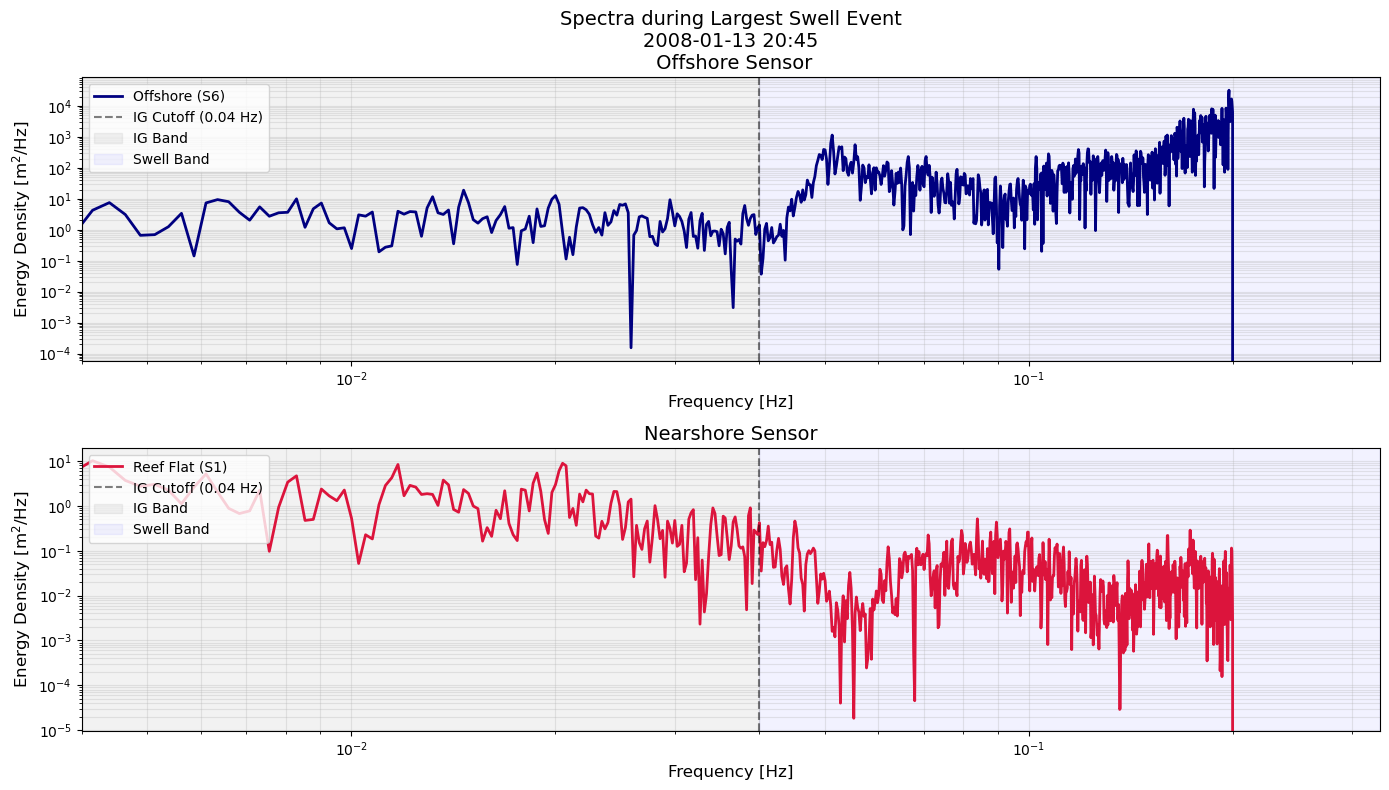

In [15]:
hs_s6 = Hs_band(S6, fmin=0.04, fmax=0.33)
print("\nTop 5 Swell Events:")
print(hs_s6.sortby(hs_s6, ascending=False).head(time=5))

t_max = hs_s6.idxmax(dim="time")
hs_max_val = hs_s6.sel(time=t_max).item()

spec6 = S6['Seta'].sel(time=t_max, method='nearest')
spec1 = S1['Seta'].sel(time=t_max, method='nearest')


# 4. Plot the spectra
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(14, 8))

# Log-log plot is standard for viewing IG and Swell bands together
ax1.loglog(spec6.frequency, spec6, label='Offshore (S6)', color='navy', linewidth=2)

# Add visual guides for frequency bands
ax1.axvline(0.04, color='k', linestyle='--', alpha=0.5, label='IG Cutoff (0.04 Hz)')
ax1.axvspan(0.004, 0.04, color='gray', alpha=0.1, label='IG Band')
ax1.axvspan(0.04, 0.33, color='blue', alpha=0.05, label='Swell Band')

# Formatting
ax1.set_xlabel('Frequency [Hz]', fontsize=12)
ax1.set_ylabel('Energy Density [m$^2$/Hz]', fontsize=12)
ax1.set_title(f'Spectra during Largest Swell Event\n{pd.to_datetime(t_max.values).strftime("%Y-%m-%d %H:%M")}\n Offshore Sensor', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, which="both", alpha=0.3)
ax1.set_xlim(0.004, 0.33)  # Focus on relevant frequencies (IG + Swell)

ax2.loglog(spec1.frequency, spec1, label='Reef Flat (S1)', color='crimson', linewidth=2)
ax2.axvline(0.04, color='k', linestyle='--', alpha=0.5, label='IG Cutoff (0.04 Hz)')
ax2.axvspan(0.004, 0.04, color='gray', alpha=0.1, label='IG Band')
ax2.axvspan(0.04, 0.33, color='blue', alpha=0.05, label='Swell Band')

ax2.set_xlabel('Frequency [Hz]', fontsize=12)
ax2.set_ylabel('Energy Density [m$^2$/Hz]', fontsize=12)
ax2.set_title(f'Nearshore Sensor', fontsize=14)
ax2.legend(loc='upper left')
ax2.grid(True, which="both", alpha=0.3)
ax2.set_xlim(0.004, 0.33)  # Focus on relevant frequencies (IG + Swell)

plt.tight_layout()
plt.show()



TypeError: sensor_spectra() got an unexpected keyword argument 'f_cutoff'

#### 3. Bispectra/Biphase analysis

- use bispectrum to quantify the phase coupling between two short waves and the resulting IG waves
- compute the biphase to see the angular offset
    - if $\beta$ ~ 180 degrees: bound wave theory holds
    - if $\beta$ ~ 90 degrees: waves are in strong shaoling/nonlinear transition. 


#### 4. If there's time:
a. **groupiness** Does higher groupiness offshore lead to higher efficiency nearshore? Compute the GF (groupiness factor)

b. **lag analysis** do cross correlation between offshore envelope and nearshore IG seignal. The time lag at peak corr should match $c_g$ from offshore sensor to the beach